<a href="https://colab.research.google.com/github/vkthakur90/Econometrics/blob/main/ARIMA_GARCH_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install.packages("quantmod", repos = "https://cran.r-project.org")
#install.packages("rugarch", repos = "https://cran.r-project.org")
#install.packages("forecast", repos = "https://cran.r-project.org")

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::first()  masks xts::first()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::last()   masks xts::last()
✖ purrr::reduce() masks rugarch::reduce()
ℹ Use the conflicted pa

[1] "NIFTYBEES.NS"

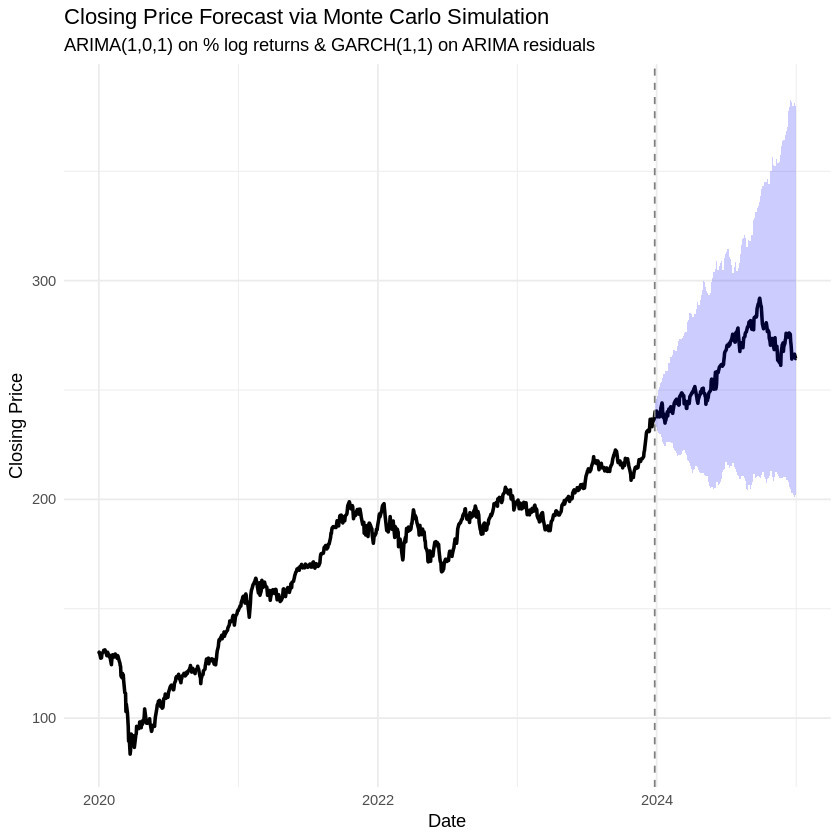

In [2]:
# Suppress xts lag warning from dplyr interfering with base R's lag
options(xts.warn_dplyr_breaks_lag = FALSE)

#############################
# Hyperparameters Section
#############################

# Data parameters
symbol <- "NIFTYBEES.NS"
start_date <- "2020-01-01"
end_date <- "2025-01-01"
train_ratio <- 0.8

# ARIMA hyperparameters
arima_order <- c(1, 0, 1)

# GARCH hyperparameters
garch_order <- c(1, 1)
garch_model <- "sGARCH"
distribution <- "norm"

# Monte Carlo simulation
N_sim <- 100

#############################
# End Hyperparameters Section
#############################

# Load necessary libraries
library(quantmod)    # For downloading stock data
library(forecast)    # For ARIMA modeling and forecasting
library(rugarch)     # For GARCH modeling
library(tidyverse)   # For data manipulation and plotting (includes ggplot2, dplyr, tidyr, tibble, etc.)

# 1. Download stock price data (Apple Inc.)
quantmod::getSymbols(symbol, src = "yahoo", from = start_date, to = end_date, auto.assign = TRUE)
prices <- quantmod::Cl(get(symbol))

# 2. Compute percentage log returns using a pipeline
returns <- prices %>%
  log() %>%
  diff() %>%
  `*`(100) %>%
  stats::na.omit()

# 3. Split data into training and testing sets
n <- length(returns)
train_size <- floor(train_ratio * n)
train_returns <- returns[1:train_size]
test_returns  <- returns[(train_size + 1):n]

# 4. Fit ARIMA model on training returns and extract residuals
arima_fit <- stats::arima(train_returns, order = arima_order)
arima_resid <- stats::residuals(arima_fit)

# 5. Fit GARCH model on ARIMA residuals
garch_spec <- rugarch::ugarchspec(
  variance.model = list(model = garch_model, garchOrder = garch_order),
  mean.model     = list(armaOrder = c(0, 0), include.mean = TRUE),
  distribution.model = distribution
)
garch_fit <- rugarch::ugarchfit(spec = garch_spec, data = arima_resid)

# 6. Forecast on the test period
forecast_horizon <- length(test_returns)
arima_forecast <- forecast::forecast(arima_fit, h = forecast_horizon)
forecast_returns <- as.numeric(arima_forecast$mean)
garch_forecast <- rugarch::ugarchforecast(garch_fit, n.ahead = forecast_horizon)
sigma_forecast <- rugarch::sigma(garch_forecast)

# 7. Monte Carlo Simulation to generate future price paths
H <- forecast_horizon
sim_matrix <- matrix(NA, nrow = H, ncol = N_sim)
last_train_price <- as.numeric(prices[train_size + 1])  # Starting price for simulation

for (i in 1:N_sim) {
  sim_returns <- sapply(1:H, function(j) {
    stats::rnorm(1, mean = forecast_returns[j], sd = sigma_forecast[j])
  })
  sim_matrix[, i] <- last_train_price * exp(cumsum(sim_returns / 100))
}

# 8. Compute 95% confidence envelope (2.5% and 97.5% quantiles) from all simulations
lower_bound <- apply(sim_matrix, 1, quantile, probs = 0.025)
upper_bound <- apply(sim_matrix, 1, quantile, probs = 0.975)

# 9. Prepare tidy data frames for plotting

# Actual prices for the entire dataset
df_actual <- tibble::tibble(Date = zoo::index(prices),
                            Price = as.numeric(prices))

# Create a tidy data frame from the simulation matrix and select a few paths (e.g., 5)
df_sim <- sim_matrix %>%
  as.data.frame() %>%
  tibble::rownames_to_column(var = "Index") %>%
  dplyr::mutate(Index = as.numeric(Index),
                Date = zoo::index(test_returns)[Index]) %>%
  tidyr::pivot_longer(cols = -c(Index, Date), names_to = "Simulation", values_to = "Price") %>%
  dplyr::filter(Simulation %in% paste0(1:5))

# Confidence envelope data frame
df_envelope <- tibble::tibble(Date = zoo::index(test_returns),
                              Lower = lower_bound,
                              Upper = upper_bound)

# 10. Display only the final plot: Actual prices, selected Monte Carlo paths, and the 95% CI envelope
ggplot2::ggplot() +
  ggplot2::geom_line(data = df_actual, ggplot2::aes(x = Date, y = Price), color = "black", linewidth = 1) +
  ggplot2::geom_ribbon(data = df_envelope, ggplot2::aes(x = Date, ymin = Lower, ymax = Upper), fill = "blue", alpha = 0.2) +
  ggplot2::geom_line(data = df_sim, ggplot2::aes(x = Date, y = Price, group = Simulation), color = "blue", alpha = 0.6) +
  ggplot2::geom_vline(xintercept = zoo::index(prices)[train_size + 1], linetype = "dashed", color = "grey50") +
  ggplot2::labs(title = "Closing Price Forecast via Monte Carlo Simulation",
                subtitle = "ARIMA(1,0,1) on % log returns & GARCH(1,1) on ARIMA residuals",
                x = "Date", y = "Closing Price") +
  ggplot2::theme_minimal()
